<center><h1>Regression Analysis for Power Plant Energy Output Prediction</h1></center>
<br>

## Combined Cycle Power Plant Data Set

### Download Data

Package imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.preprocessing import PolynomialFeatures
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import euclidean_distances

Get the Cycle Power Plant Data Set

In [2]:
df = pd.read_excel('../data/CCPP/Folds5x2_pp.xlsx')
df.head()

AT      V       AP     RH      PE
0  14.96  41.76  1024.07  73.17  463.26
1  25.18  62.96  1020.04  59.08  444.37
2   5.11  39.40  1012.16  92.14  488.56
3  20.86  57.32  1010.24  76.64  446.48
4  10.82  37.50  1009.23  96.62  473.90

### Exploring the data

#### i. rows and columns

In [3]:
print('Number of Rows in the dataset =', df.shape[0])
print('Number of Columns in the dataset =', df.shape[1])

Number of Rows in the dataset = 9568
Number of Columns in the dataset = 5


Q: What do the rows and columns represent? 

A: Each column in the dataset represents a feature 'X<sub>i</sub>' which we can use to predict our 'Y' - in this case, net hourly electrical energy output of the plant; PE. 

List of Features 'X<sub>i</sub>' that we have in this dataset:

1. Temperature (AT)
2. Exhaust Vacuum (V)
3. Ambient Pressure (AP)
4. Relative Humidity (RH)

The row values represent the corresponding (x<sub>i</sub>, y<sub>i</sub>) feature-target pairs.

#### ii. pairwise scatterplots of all the variables

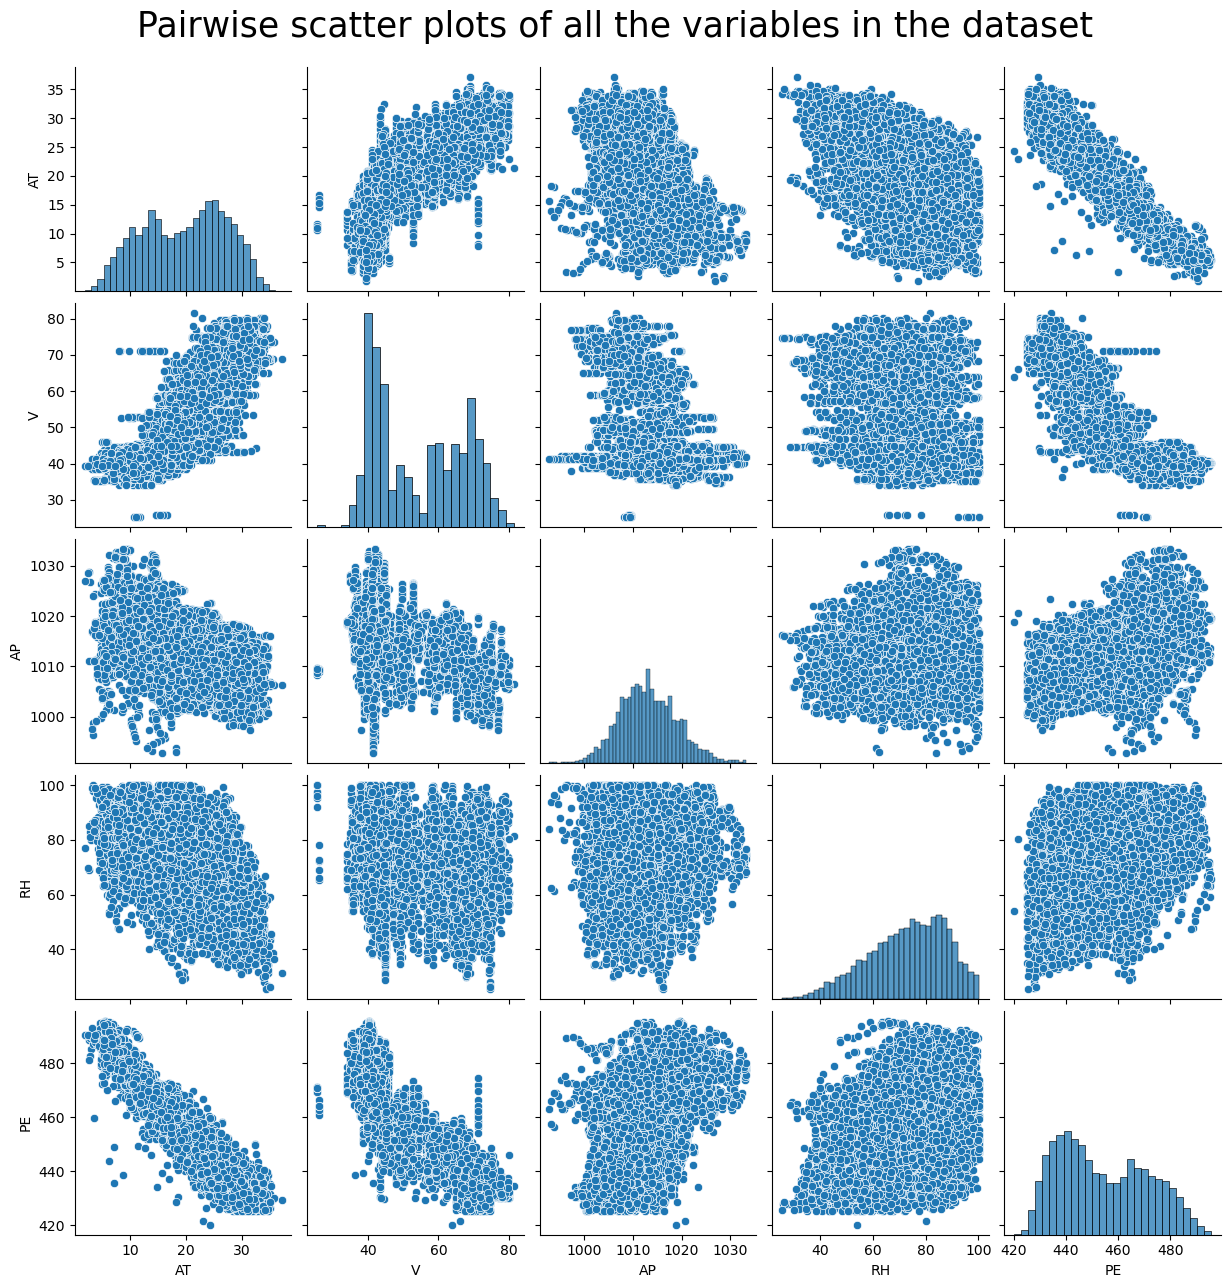

In [4]:
fig = sns.pairplot(df)
fig.fig.suptitle('Pairwise scatter plots of all the variables in the dataset', y=1.03, fontsize=25)
plt.show()

* Findings: 

1. AT and V seem to be positively correlated.
2. AT and PE seem to be negatively correlated.
3. V and PE seem to be negatively correlated.

#### iii. mean, the median, range, first and third quartiles, and interquartile ranges

In [5]:
def summary_stats(df):
    summary = pd.DataFrame(df.describe())
    summary = summary.transpose()
    summary['Range'] = summary['max'] - summary['min']
    summary['Inter Quartile Range'] = summary['75%'] - summary['25%']
    summary = summary[['mean', '50%', 'Range', '25%', '75%', 'Inter Quartile Range']]
    summary = summary.rename(columns={'mean': 'Mean', '50%': 'Median', '25%': 'First Quartile', '75%': 'Third Quartile'})
                                      
    return summary

summary_stats(df)

Mean    Median  Range  First Quartile  Third Quartile  \
AT    19.651231    20.345  35.30         13.5100           25.72   
V     54.305804    52.080  56.20         41.7400           66.54   
AP  1013.259078  1012.940  40.41       1009.1000         1017.26   
RH    73.308978    74.975  74.60         63.3275           84.83   
PE   454.365009   451.550  75.50        439.7500          468.43   

    Inter Quartile Range  
AT               12.2100  
V                24.8000  
AP                8.1600  
RH               21.5025  
PE               28.6800

### Simple Linear Regression

Regression Results for predictor AT and response PE:

Beta_hat_0 = 497.03411989276617
Beta_hat_1 = -2.1713199585177856


                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.899
Model:                            OLS   Adj. R-squared:                  0.899
Method:                 Least Squares   F-statistic:                 8.510e+04
Date:                Fri, 22 Sep 2023   Prob (F-statistic):               0.00
Time:                        15:11:14   Log-Likelihood:                -29756.
No. Observations:                9568   AIC:                         5.952e+04
Df Residuals:                    9566   BIC:                         5.953e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------

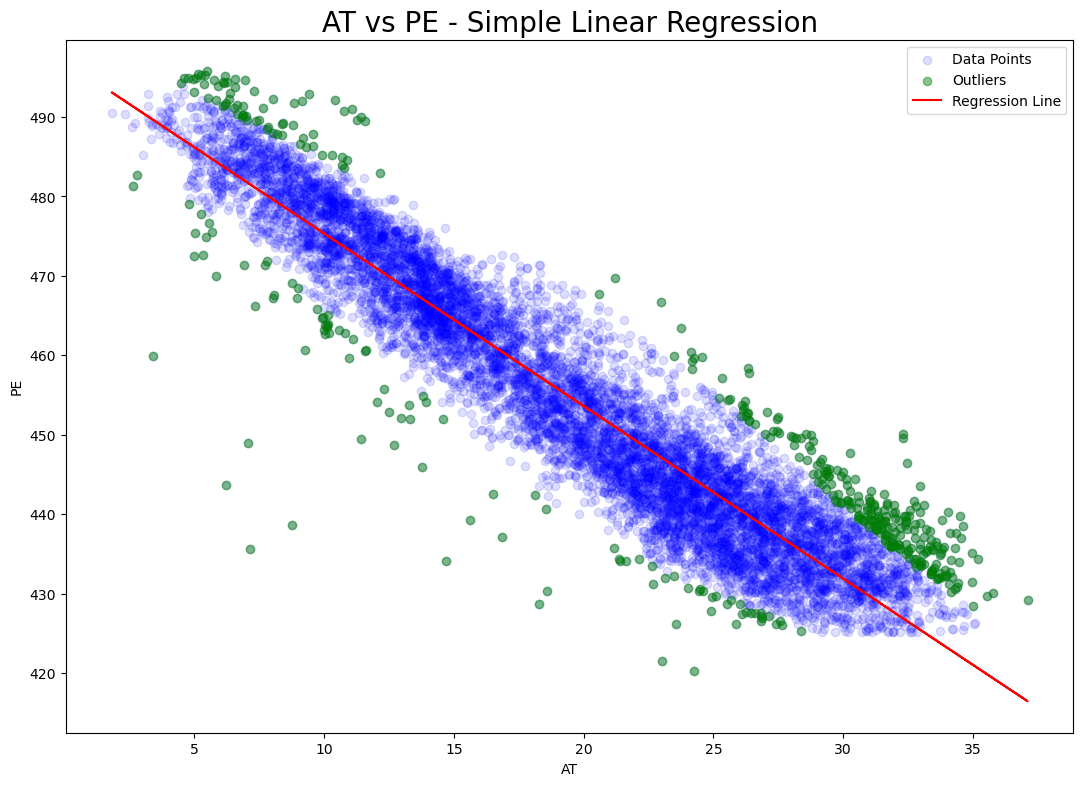

No of outliers = 416

Outliers:

         AT      PE
21     5.41  495.24
61    29.01  446.22
87    32.72  437.99
89    35.56  429.69
121   27.54  450.22
...     ...     ...
9452  33.20  438.12
9475  30.26  442.98
9477  34.03  440.29
9542   5.01  475.34
9559  26.22  454.20

[416 rows x 2 columns]


In [6]:
# AT vs PE - simple linear regression model
X = df['AT']
y = df['PE']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()

print('Regression Results for predictor AT and response PE:\n')
beta_hat_0_at = model.params[0]
beta_hat_1_at = model.params[1]
print('Beta_hat_0 =', beta_hat_0_at)
print('Beta_hat_1 =', beta_hat_1_at)
print('\n')
print(model.summary())

# Get outliers using Cook's distance
threshold = 4 / len(df)
influence = model.get_influence()
c = influence.cooks_distance[0]
outliers_at = np.where(c > threshold)

# Plot the regression line and the outliers
plt.figure(figsize=(13, 9))
plt.scatter(df['AT'], df['PE'], alpha=0.13, color='blue', label='Data Points')
plt.scatter(df['AT'].iloc[outliers_at], df['PE'].iloc[outliers_at], alpha=0.45, color='green', label='Outliers')
plt.plot(df['AT'], model.predict(), color='red', label='Regression Line')
plt.title('AT vs PE - Simple Linear Regression', fontsize=20)
plt.xlabel('AT')
plt.ylabel('PE')
plt.legend()
plt.show()

print('No of outliers =', len(outliers_at[0]))
print('\nOutliers:\n')
print(df[['AT', 'PE']].iloc[outliers_at])

Regression Results for predictor V and response PE:

Beta_hat_0 = 517.8015263083857
Beta_hat_1 = -1.168135126555712


                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.757
Model:                            OLS   Adj. R-squared:                  0.756
Method:                 Least Squares   F-statistic:                 2.972e+04
Date:                Fri, 22 Sep 2023   Prob (F-statistic):               0.00
Time:                        15:11:14   Log-Likelihood:                -33963.
No. Observations:                9568   AIC:                         6.793e+04
Df Residuals:                    9566   BIC:                         6.794e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------

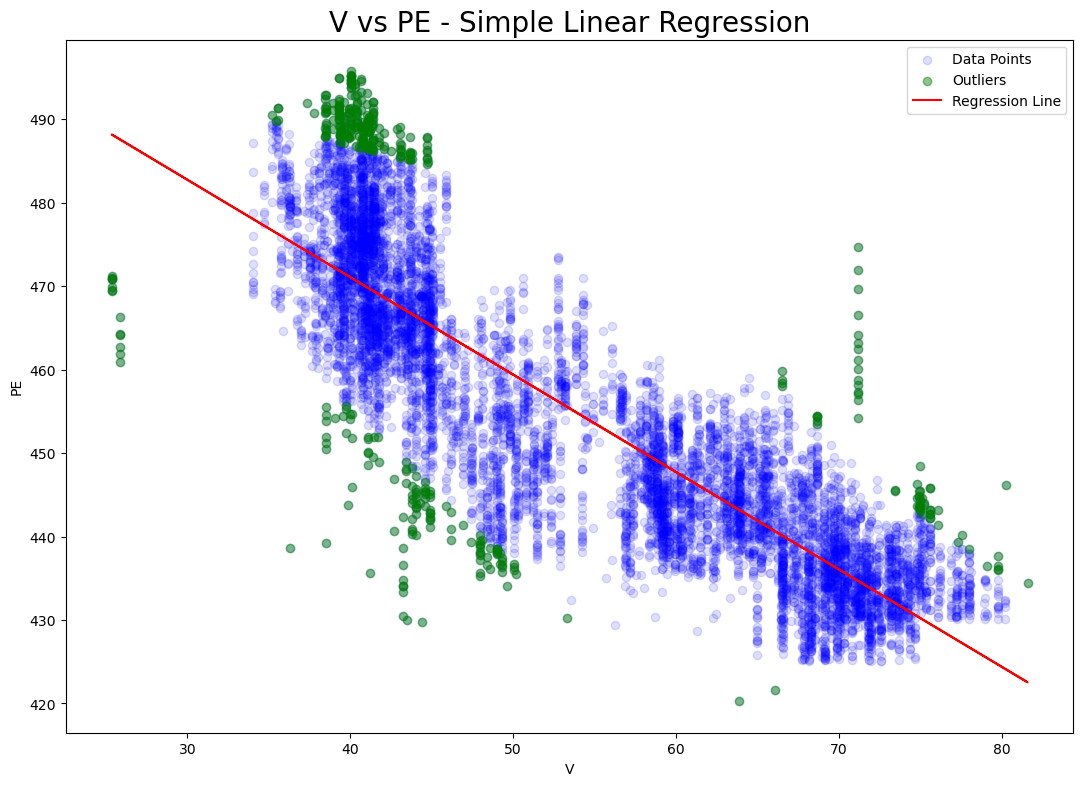

No of outliers = 423

Outliers:

          V      PE
2     39.40  488.56
21    40.07  495.24
24    48.60  436.06
47    43.43  448.06
57    39.33  491.49
...     ...     ...
9359  75.23  443.78
9394  39.72  455.58
9404  44.89  445.45
9471  43.77  446.05
9509  25.36  470.90

[423 rows x 2 columns]


In [7]:
# V vs PE - simple linear regression model
X = df['V']
y = df['PE']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()

print('Regression Results for predictor V and response PE:\n')
beta_hat_0_v = model.params[0]
beta_hat_1_v = model.params[1]
print('Beta_hat_0 =', beta_hat_0_v)
print('Beta_hat_1 =', beta_hat_1_v)
print('\n')
print(model.summary())

# Get outliers using Cook's distance
threshold = 4 / len(df)
influence = model.get_influence()
c = influence.cooks_distance[0]
outliers_v = np.where(c > threshold)

# Plot the regression line and the outliers
plt.figure(figsize=(13, 9))
plt.scatter(df['V'], df['PE'], alpha=0.13, color='blue', label='Data Points')
plt.scatter(df['V'].iloc[outliers_v], df['PE'].iloc[outliers_v], alpha=0.45, color='green', label='Outliers')
plt.plot(df['V'], model.predict(), color='red', label='Regression Line')
plt.title('V vs PE - Simple Linear Regression', fontsize=20)
plt.xlabel('V')
plt.ylabel('PE')
plt.legend()
plt.show()

print('No of outliers =', len(outliers_v[0]))
print('\nOutliers:\n')
print(df[['V', 'PE']].iloc[outliers_v])

Regression Results for predictor AP and response PE:

Beta_hat_0 = -1055.260988984438
Beta_hat_1 = 1.4898716733991142


                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.269
Model:                            OLS   Adj. R-squared:                  0.269
Method:                 Least Squares   F-statistic:                     3516.
Date:                Fri, 22 Sep 2023   Prob (F-statistic):               0.00
Time:                        15:11:15   Log-Likelihood:                -39224.
No. Observations:                9568   AIC:                         7.845e+04
Df Residuals:                    9566   BIC:                         7.847e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------

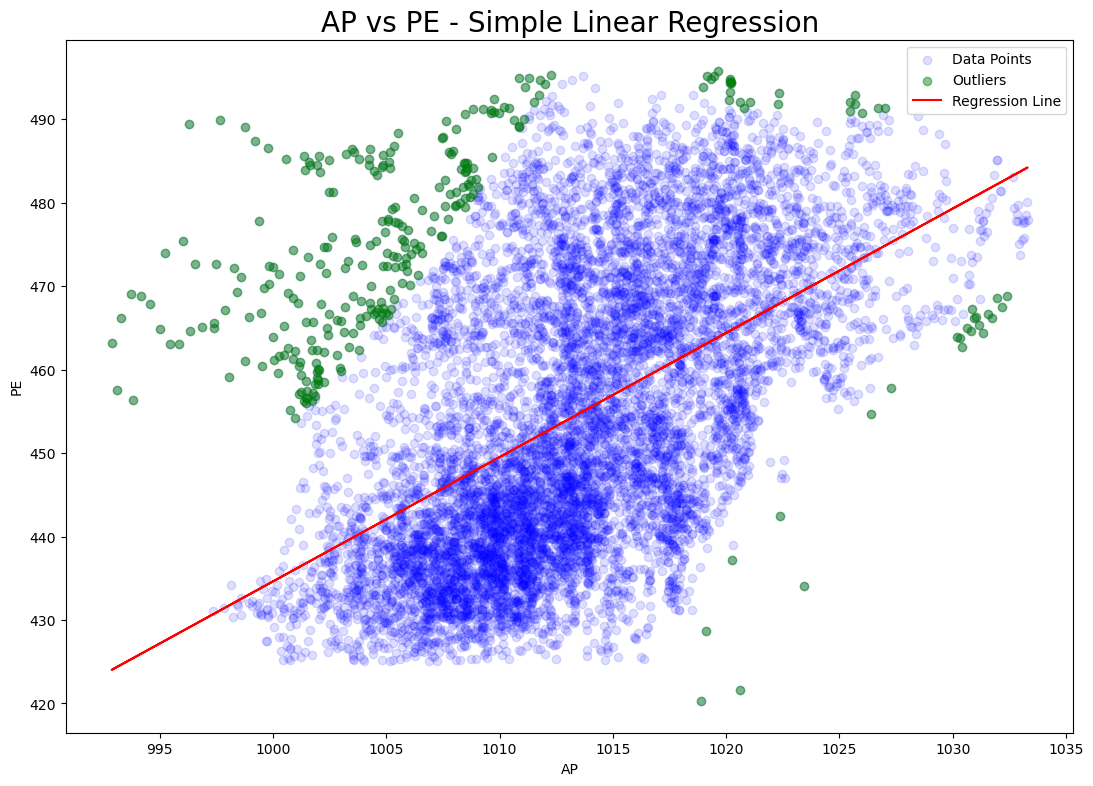

No of outliers = 300

Outliers:

           AP      PE
21    1019.16  495.24
22    1008.52  483.80
57    1010.18  491.49
74    1008.82  481.09
114   1001.24  459.36
...       ...     ...
9366  1030.61  464.95
9459  1008.43  484.75
9483  1005.24  479.22
9521   998.27  472.16
9542  1003.69  475.34

[300 rows x 2 columns]


In [8]:
# AP vs PE - simple linear regression model
X = df['AP']
y = df['PE']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()

print('Regression Results for predictor AP and response PE:\n')
beta_hat_0_ap = model.params[0]
beta_hat_1_ap = model.params[1]
print('Beta_hat_0 =', beta_hat_0_ap)
print('Beta_hat_1 =', beta_hat_1_ap)
print('\n')
print(model.summary())

# Get outliers using Cook's distance
threshold = 4 / len(df)
influence = model.get_influence()
c = influence.cooks_distance[0]
outliers_ap = np.where(c > threshold)

# Plot the regression line and the outliers
plt.figure(figsize=(13, 9))
plt.scatter(df['AP'], df['PE'], alpha=0.13, color='blue', label='Data Points')
plt.scatter(df['AP'].iloc[outliers_ap], df['PE'].iloc[outliers_ap], alpha=0.45, color='green', label='Outliers')
plt.plot(df['AP'], model.predict(), color='red', label='Regression Line')
plt.title('AP vs PE - Simple Linear Regression', fontsize=20)
plt.xlabel('AP')
plt.ylabel('PE')
plt.legend()
plt.show()

print('No of outliers =', len(outliers_ap[0]))
print('\nOutliers:\n')
print(df[['AP', 'PE']].iloc[outliers_ap])

Regression Results for predictor RH and response PE:

Beta_hat_0 = 420.9617661554838
Beta_hat_1 = 0.45565010226298336


                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.152
Model:                            OLS   Adj. R-squared:                  0.152
Method:                 Least Squares   F-statistic:                     1714.
Date:                Fri, 22 Sep 2023   Prob (F-statistic):               0.00
Time:                        15:11:15   Log-Likelihood:                -39933.
No. Observations:                9568   AIC:                         7.987e+04
Df Residuals:                    9566   BIC:                         7.988e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------

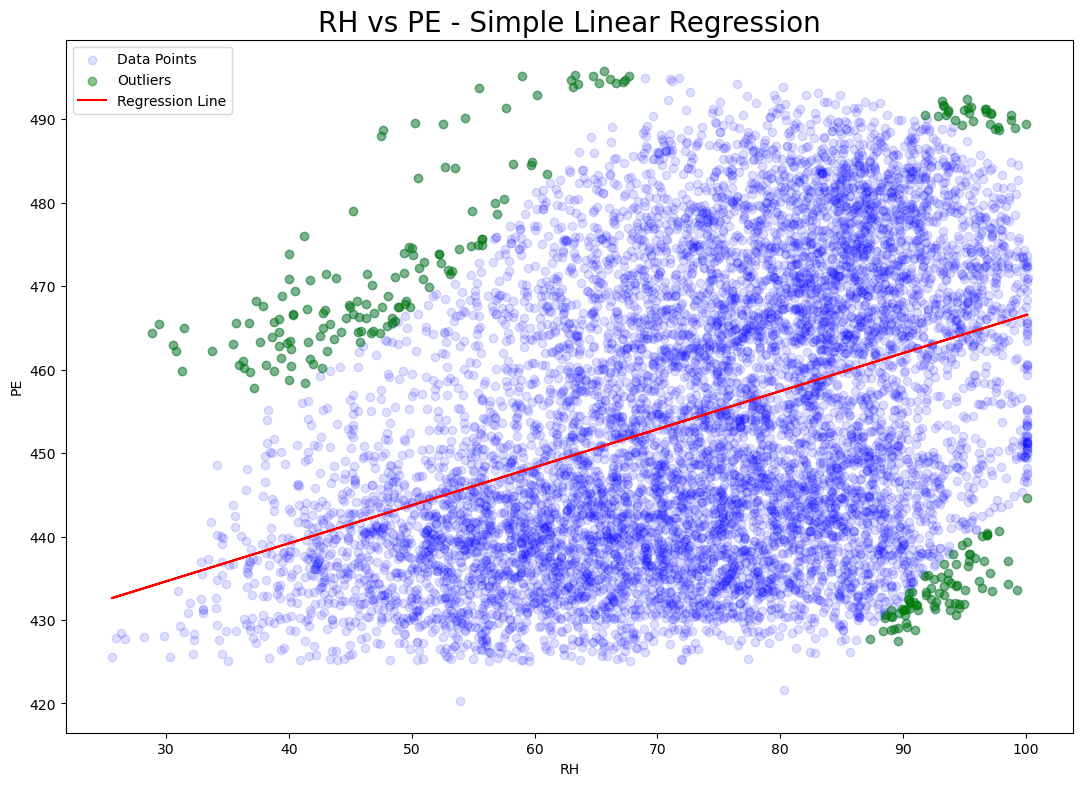

No of outliers = 249

Outliers:

         RH      PE
8     41.25  475.98
15    43.08  462.19
16    48.84  467.54
21    64.77  495.24
48    50.00  474.60
...     ...     ...
9124  97.21  490.68
9204  98.84  490.50
9361  90.20  430.55
9469  93.39  434.11
9495  99.27  433.62

[249 rows x 2 columns]


In [9]:
# RH vs PE - simple linear regression model
X = df['RH']
y = df['PE']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()

print('Regression Results for predictor RH and response PE:\n')
beta_hat_0_rh = model.params[0]
beta_hat_1_rh = model.params[1]
print('Beta_hat_0 =', beta_hat_0_rh)
print('Beta_hat_1 =', beta_hat_1_rh)
print('\n')
print(model.summary())

# Get outliers using Cook's distance
threshold = 4 / len(df)
influence = model.get_influence()
c = influence.cooks_distance[0]
outliers_rh = np.where(c > threshold)

# Plot the regression line and the outliers
plt.figure(figsize=(13, 9))
plt.scatter(df['RH'], df['PE'], alpha=0.13, color='blue', label='Data Points')
plt.scatter(df['RH'].iloc[outliers_rh], df['PE'].iloc[outliers_rh], alpha=0.45, color='green', label='Outliers')
plt.plot(df['RH'], model.predict(), color='red', label='Regression Line')
plt.title('RH vs PE - Simple Linear Regression', fontsize=20)
plt.xlabel('RH')
plt.ylabel('PE')
plt.legend()
plt.show()

print('No of outliers =', len(outliers_rh[0]))
print('\nOutliers:\n')
print(df[['RH', 'PE']].iloc[outliers_rh])

### Multiple Regression

In [10]:
# multiple regression model
X = df[['AT', 'V', 'AP', 'RH']]
y = df['PE']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()

print('Regression Results for predictors AT, V, AP, RH and response PE:\n')
print('Beta_hat_0 =', model.params[0])
print('Beta_hat_1 =', model.params[1])
print('Beta_hat_2 =', model.params[2])
print('Beta_hat_3 =', model.params[3])
print('Beta_hat_4 =', model.params[4])
print('\n')
print(model.summary())

Regression Results for predictors AT, V, AP, RH and response PE:

Beta_hat_0 = 454.6092743153162
Beta_hat_1 = -1.9775131066353744
Beta_hat_2 = -0.23391642258250134
Beta_hat_3 = 0.06208294378085466
Beta_hat_4 = -0.15805410291641542


                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.929
Model:                            OLS   Adj. R-squared:                  0.929
Method:                 Least Squares   F-statistic:                 3.114e+04
Date:                Fri, 22 Sep 2023   Prob (F-statistic):               0.00
Time:                        15:11:15   Log-Likelihood:                -28088.
No. Observations:                9568   AIC:                         5.619e+04
Df Residuals:                    9563   BIC:                         5.622e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                   

Inference: Since, p-value for all the predictors is 0, we reject the null hypothesis for all predictors.

### Comparing Univariate Linear Regression vs Multiple Regression Coefficients

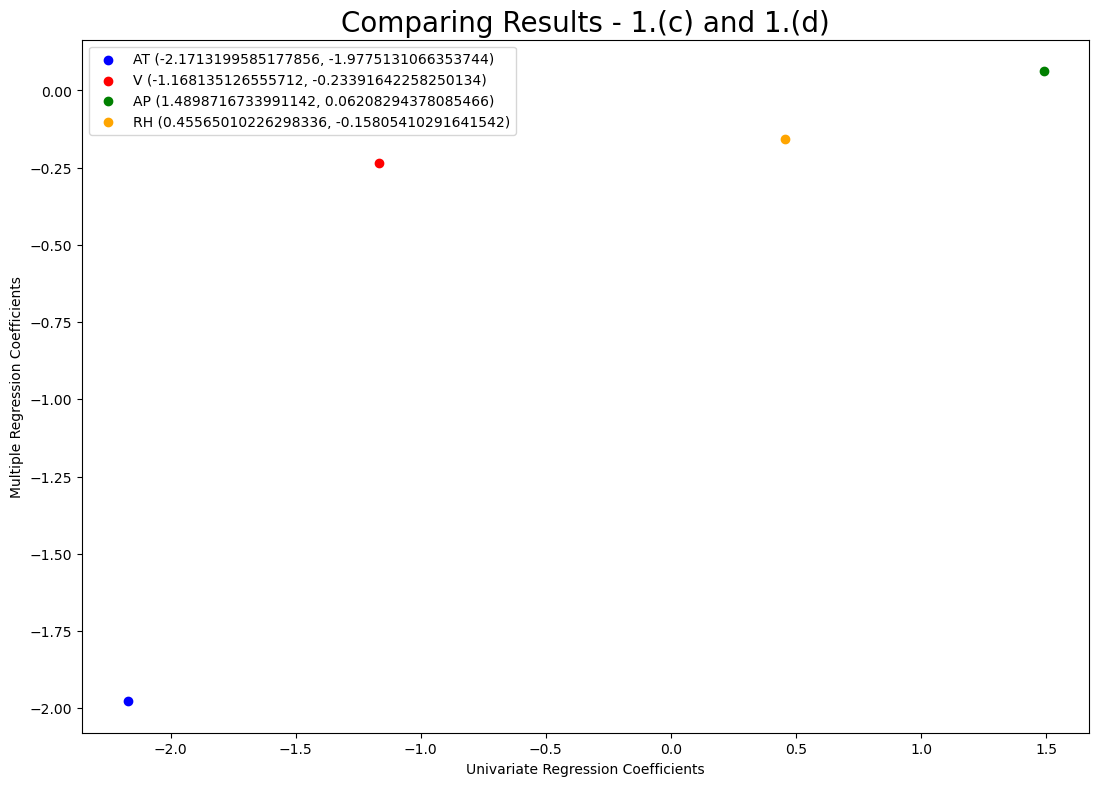

In [11]:
plt.figure(figsize=(13, 9))
plt.scatter(beta_hat_1_at, model.params[1], color='blue', label='AT ({}, {})'.format(beta_hat_1_at, model.params[1]))
plt.scatter(beta_hat_1_v, model.params[2], color='red', label='V ({}, {})'.format(beta_hat_1_v, model.params[2]))
plt.scatter(beta_hat_1_ap, model.params[3], color='green', label='AP ({}, {})'.format(beta_hat_1_ap, model.params[3]))
plt.scatter(beta_hat_1_rh, model.params[4], color='orange', label='RH ({}, {})'.format(beta_hat_1_rh, model.params[4]))
plt.title('Comparing Results - 1.(c) and 1.(d)', fontsize=20)
plt.xlabel('Univariate Regression Coefficients')
plt.ylabel('Multiple Regression Coefficients')
plt.legend()
plt.show()

### Nonlinear Association

In [12]:
X = df[['AT']]
y = df['PE']
X = PolynomialFeatures(degree=3).fit_transform(X)
model = sm.OLS(y, X).fit()

print('Checking for non-linear association between AT and PE:\n')
print(model.summary())

Checking for non-linear association between AT and PE:

                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.912
Model:                            OLS   Adj. R-squared:                  0.912
Method:                 Least Squares   F-statistic:                 3.299e+04
Date:                Fri, 22 Sep 2023   Prob (F-statistic):               0.00
Time:                        15:11:15   Log-Likelihood:                -29101.
No. Observations:                9568   AIC:                         5.821e+04
Df Residuals:                    9564   BIC:                         5.824e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------

In [13]:
X = df[['V']]
y = df['PE']
X = PolynomialFeatures(degree=3).fit_transform(X)
model = sm.OLS(y, X).fit()

print('Checking for non-linear association between V and PE:\n')
print(model.summary())

Checking for non-linear association between V and PE:

                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.775
Model:                            OLS   Adj. R-squared:                  0.775
Method:                 Least Squares   F-statistic:                 1.098e+04
Date:                Fri, 22 Sep 2023   Prob (F-statistic):               0.00
Time:                        15:11:16   Log-Likelihood:                -33585.
No. Observations:                9568   AIC:                         6.718e+04
Df Residuals:                    9564   BIC:                         6.721e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------

In [14]:
X = df[['AP']]
y = df['PE']
X = PolynomialFeatures(degree=3).fit_transform(X)
model = sm.OLS(y, X).fit()

print('Checking for non-linear association between AP and PE:\n')
print(model.summary())

Checking for non-linear association between AP and PE:

                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.275
Model:                            OLS   Adj. R-squared:                  0.275
Method:                 Least Squares   F-statistic:                     1813.
Date:                Fri, 22 Sep 2023   Prob (F-statistic):               0.00
Time:                        15:11:16   Log-Likelihood:                -39184.
No. Observations:                9568   AIC:                         7.837e+04
Df Residuals:                    9565   BIC:                         7.840e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------

In [15]:
X = df[['RH']]
y = df['PE']
X = PolynomialFeatures(degree=3).fit_transform(X)
model = sm.OLS(y, X).fit()

print('Checking for non-linear association between RH and PE:\n')
print(model.summary())

Checking for non-linear association between RH and PE:

                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.154
Model:                            OLS   Adj. R-squared:                  0.153
Method:                 Least Squares   F-statistic:                     579.2
Date:                Fri, 22 Sep 2023   Prob (F-statistic):               0.00
Time:                        15:11:16   Log-Likelihood:                -39923.
No. Observations:                9568   AIC:                         7.985e+04
Df Residuals:                    9564   BIC:                         7.988e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------

Inference for evidence of nonlinear association between any of the predictors and the response:

AT, AP, RH ---> P value is 0 for all coefficients ---> Reject Null Hypothesis ---> Evidence of non-linear association between [AT, AP, RH] and PE.

V ---> P value for x2 is high ---> Reject Alternate Hypothesis ---> No evidence of non-linear association between V and PE.

### Interactions of Predictors

In [16]:
interaction = 'PE ~ AT + V + AP + RH + AT*V + AT*AP + AT*RH + V*AP + V*RH + AP*RH'
model = smf.ols(formula=interaction, data=df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.936
Model:                            OLS   Adj. R-squared:                  0.936
Method:                 Least Squares   F-statistic:                 1.405e+04
Date:                Fri, 22 Sep 2023   Prob (F-statistic):               0.00
Time:                        15:11:16   Log-Likelihood:                -27548.
No. Observations:                9568   AIC:                         5.512e+04
Df Residuals:                    9557   BIC:                         5.520e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    685.7825     78.640      8.721      0.0

Inference:

Considering p-value = 0.05,

V:RH, AT:AP ---> statistically insignificant

All the other features are statistically significant.


### Improvement

In [17]:
ids = np.arange(len(df))
np.random.seed(1000) 
np.random.shuffle(ids)

tr_ids, te_ids = ids[:(int)(0.7*len(df))], ids[(int)(0.7*len(df)):]
train = df.iloc[tr_ids]
test = df.iloc[te_ids]


X = df[['AT', 'V', 'AP', 'RH']]
y = df['PE']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=37) 

print(train.shape)
print(test.shape)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(6697, 5)
(2871, 5)
(6697, 4)
(2871, 4)
(6697,)
(2871,)


In [18]:
def lrm(formula):
    model = smf.ols(formula=formula, data=train).fit()
    print(model.summary())
    pred_train_y = model.predict(X_train)
    pred_test_y = model.predict(X_test)
    train_mse = mean_squared_error(y_train, pred_train_y)
    test_mse = mean_squared_error(y_test, pred_test_y)

    print('\n\nSummary:\n')
    print('Formula = {}\n'.format(formula))
    print('Train MSE =', train_mse)
    print('Test MSE =', test_mse)    

In [19]:
# Formula 1 - All predictors
lrm('PE ~ AT + V + AP + RH')

                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.927
Model:                            OLS   Adj. R-squared:                  0.927
Method:                 Least Squares   F-statistic:                 2.138e+04
Date:                Fri, 22 Sep 2023   Prob (F-statistic):               0.00
Time:                        15:11:16   Log-Likelihood:                -19712.
No. Observations:                6697   AIC:                         3.943e+04
Df Residuals:                    6692   BIC:                         3.947e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    450.5234     11.712     38.468      0.0

Inference: In the current run, since p-values for all predictors = 0, we can't rule any of them out as being statistically insignificant.

In [20]:
# Formula 2 - Predictors with interaction terms and quadratic terms
lrm('PE ~ AT + V + AP + RH + np.power(AT, 2) + np.power(V, 2) + np.power(AP, 2) + np.power(RH, 2) + AT*V + AT*AP + AT*RH + V*AP + V*RH + AP*RH')

                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.936
Model:                            OLS   Adj. R-squared:                  0.936
Method:                 Least Squares   F-statistic:                     7023.
Date:                Fri, 22 Sep 2023   Prob (F-statistic):               0.00
Time:                        15:11:16   Log-Likelihood:                -19272.
No. Observations:                6697   AIC:                         3.857e+04
Df Residuals:                    6682   BIC:                         3.868e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept       -7869.4231   1447.735     



Summary:

Formula = PE ~ AT + V + AP + RH + np.power(AT, 2) + np.power(V, 2) + np.power(AP, 2) + np.power(RH, 2) + AT*V + AT*AP + AT*RH + V*AP + V*RH + AP*RH

Train MSE = 18.274503159353696
Test MSE = 17.74796178911102


Inference: 

1. In the current run, since p-values for predictors [(V<sup>2</sup>), (AT:AP), (V:AP), (V:RH)] > 0.05, we can rule them out as being statistically insignificant from the next run.

2. It is important to note that even though p-values for features AT, V are greater than 0.05, we can't rule them out because of the hierarchical principle.

3. All the other features with p-val < 0.05 seem to be statistically significant.

In [21]:
# Formula 3 - Predictors with interaction terms and quadratic terms after removing insignificant predictors
lrm('PE ~ AT + V + AP + RH + np.power(AT, 2) + np.power(AP, 2) + np.power(RH, 2) + AT*V + AT*RH + AP*RH')

                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.936
Model:                            OLS   Adj. R-squared:                  0.936
Method:                 Least Squares   F-statistic:                     9817.
Date:                Fri, 22 Sep 2023   Prob (F-statistic):               0.00
Time:                        15:11:16   Log-Likelihood:                -19279.
No. Observations:                6697   AIC:                         3.858e+04
Df Residuals:                    6686   BIC:                         3.865e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept       -1.037e+04   1109.636     




Summary:

Formula = PE ~ AT + V + AP + RH + np.power(AT, 2) + np.power(AP, 2) + np.power(RH, 2) + AT*V + AT*RH + AP*RH

Train MSE = 18.29906400767009
Test MSE = 17.806296214819223


### KNN

Optimal k value = 8
Minimum Test MSE = 16.200532918625914
Train MSE at Optimal k = 12.424608248796103




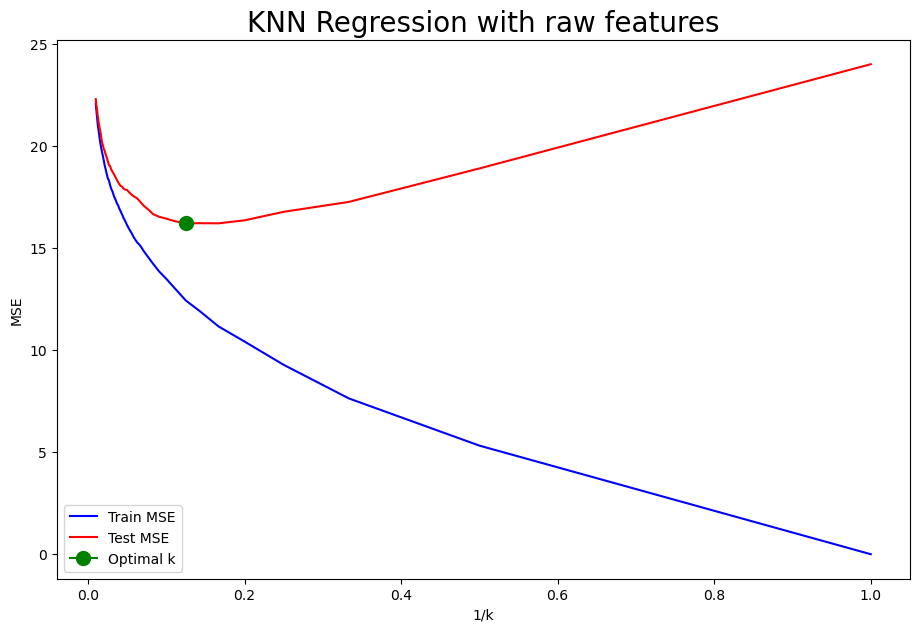

In [22]:
# KNN Regression with raw features
min_index = 0
train_mse_list = []
test_mse_list = []
k_list = np.arange(1, 101)

for k in k_list:
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(X_train, y_train)
    pred_y_train = knn.predict(X_train)
    pred_y_test = knn.predict(X_test)
    train_mse = mean_squared_error(y_train, pred_y_train)
    test_mse = mean_squared_error(y_test, pred_y_test)
    train_mse_list.append(train_mse)
    test_mse_list.append(test_mse)
    if test_mse < test_mse_list[min_index]:
        min_index = k - 1

print('Optimal k value =', k_list[min_index])
print('Minimum Test MSE =', test_mse_list[min_index])
print('Train MSE at Optimal k =', train_mse_list[min_index])
print('\n')

plt.figure(figsize=(11, 7))
plt.plot(1/k_list, train_mse_list, color='blue', label='Train MSE')
plt.plot(1/k_list, test_mse_list, color='red', label='Test MSE')
plt.plot(1/k_list[min_index], test_mse_list[min_index], color='green', marker='o', markersize=10, label='Optimal k')
plt.title('KNN Regression with raw features', fontsize=20)
plt.xlabel('1/k')
plt.ylabel('MSE')
plt.legend()
plt.show()

Optimal k value = 6
Minimum Test MSE = 14.993244631177683
Train MSE at Optimal k = 9.920908581371433




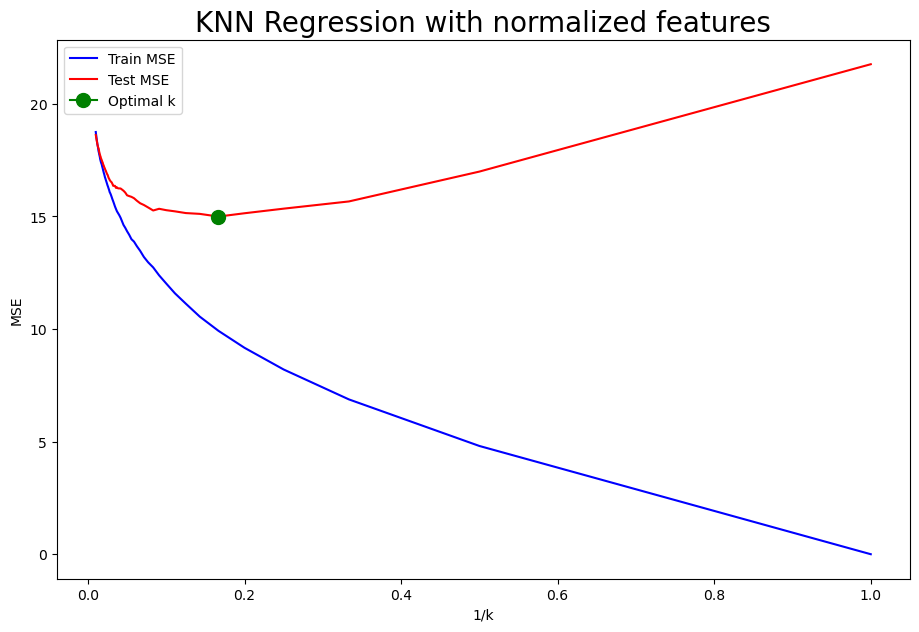

In [23]:
# KNN Regression with normalized features
min_index = 0
train_mse_list = []
test_mse_list = []
k_list = np.arange(1, 101)

scaler = MinMaxScaler()
X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.transform(X_test)

for k in k_list:
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(X_train_norm, y_train)
    pred_y_train = knn.predict(X_train_norm)
    pred_y_test = knn.predict(X_test_norm)
    train_mse = mean_squared_error(y_train, pred_y_train)
    test_mse = mean_squared_error(y_test, pred_y_test)
    train_mse_list.append(train_mse)
    test_mse_list.append(test_mse)
    if test_mse < test_mse_list[min_index]:
        min_index = k - 1

print('Optimal k value =', k_list[min_index])
print('Minimum Test MSE =', test_mse_list[min_index])
print('Train MSE at Optimal k =', train_mse_list[min_index])
print('\n')

plt.figure(figsize=(11, 7))
plt.plot(1/k_list, train_mse_list, color='blue', label='Train MSE')
plt.plot(1/k_list, test_mse_list, color='red', label='Test MSE')
plt.plot(1/k_list[min_index], test_mse_list[min_index], color='green', marker='o', markersize=10, label='Optimal k')
plt.title('KNN Regression with normalized features', fontsize=20)
plt.xlabel('1/k')
plt.ylabel('MSE')
plt.legend()
plt.show()

### Compare KNN and Linear Regression

Results of KNN Regression and Linear Regression Combined (From my last run):


| Model | Test Error | Train Error |
| -------- | -------- | -------- |
| KNN Regression with Raw Features (Refer 1i) | 16.200532918625914 | 12.424608248796103 |
| KNN Regression with Normalized Features (Refer 1i) | 14.993244631177683 | 9.920908581371433 |
| Linear Regression with all predictors (Refer 1h - Formula 1) | 20.22119759087075 | 21.00613013702481 |
| Linear Regression with all predictors, interaction terms and quadratic terms (Refer 1h - Formula 2) | 17.74796178911102 | 18.274503159353696 |
| Linear Regression with all predictors, interaction terms and quadratic terms after removing insignificant predictors (Refer 1h - Formula 3) | 17.806296214819223 | 18.29906400767009 |

KNN Regression with normalized features performs the best in terms of test error. This maybe because linear regression models would not have been able to capture the pattern of our data well. 

## Practice Question - ISLR: 2.4.1

### (a) The sample size n is extremely large, and the number of predictors p is small.

A: If the sample size n is extremely large and the number of predictors p is small then the performance of a flexible statistical learning method would be better than an inflexible statistical learning method as it'll be able to capture the dataset's patterns and relationships better and won't underfit.

### (b) The number of predictors p is extremely large, and the number of observations n is small.

A: If the number of predictors p is extremely large and the number of observations n is small then the performance of a flexible statistical learning method would be worse than an inflexible statistical learning method as the latter won't overfit.

### (c) The relationship between the predictors and response is highly non-linear.

A: Relationship betweem the predictors and response being highly non-linear implies that the dataset might contain complex patterns. A flexible statistical method captures these complex patterns better and hence would perform better when compared to an inflexible statistical method. 

### (d) The variance of the error terms, i.e. $σ^2$ = Var(ε), is extremely high.

A: High variance of the error terms suggests that the dataset contains a substantial amount of noise. A flexible statistical method will try to capture this noise and eventually lead to overfitting and poor generalization. Hence, it will perform worse in this case when compared to an inflexible statistical method.

## Practice Question - ISLR: 2.4.7

### (a) Compute the Euclidean distance between each observation and the test point, X1 = X2 = X3 = 0.

In [24]:
training_dataset = [
    [0, 3, 0],
    [2, 0, 0],
    [0, 1, 3],
    [0, 1, 2],
    [-1, 0, 1],
    [1, 1, 1]
]

point = [0, 0, 0]

ed = euclidean_distances([point], training_dataset)
print('Euclidean Distance between each observation and the test point:\n')
k = 1
for i in ed[0]:
    print(k, i)
    k += 1

Euclidean Distance between each observation and the test point:

1 3.0
2 2.0
3 3.1622776601683795
4 2.23606797749979
5 1.4142135623730951
6 1.7320508075688772


### (b) What is our prediction with K = 1? Why?

A: Since K = 1, we consider the closest point (neighbor) to [0, 0, 0]. Based on the euclidean distance measures computed above that distance = 1.4142135623730951 for feature vector [-1, 0, 1]. This corresponds to Y = Green. Therefore, our prediction will be <b>Green</b>.

### (c) What is our prediction with K = 3? Why?

A: Since K = 3, we consider the 3 closest points (neighbors) to [0, 0, 0]. Based on the euclidean distance measures computed above those distances are 1.4142135623730951, 1.7320508075688772, 2.0 for feature vectors [-1, 0, 1], [1, 1, 1], [2, 0, 0] respectively. These correspond to Y = Green, Red, Red respectively. Therefore, our prediction will be <b>Red</b> because it's the majority class.

### (d) If the Bayes decision boundary in this problem is highly non-linear, then would we expect the best value for K to be large or small? Why?

A: If the Bayes decision boundary is highly non-linear, it implies that the estimator is flexible. As flexibility increases, K value decreases. This in turn implies that we can expect the best value for K to be <b>small</b>.